<a href="https://colab.research.google.com/github/ysmnpksy/Final-Project/blob/main/Set2_LSTMGRU_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>LSTM & GRU Layers</h1>
By Yasmin Paksoy

# Table of Contents 
  * [Preparing the Data](#section1)
  * [Build Functions](#build)
  * [Model 1: First LSTM Model](#model2)
  * [Tuning: Dropout](#dropout)
    * [Model 2: Rate 20%](#model3)
    * [Model 3: Rate 40%](#model4)
    * [Model 4: Rate 50%](#model5)
  * [Tuning: Number of Layers](#layers)
    * [Failed Model: 2 Layers](#model6)
  * [Model 5: GRU](#model7)
  * [Tuning Learning Rate](#Learning-Rate)
    * [Model 6: 0.003](#model8)
    * [Model 7: 0.006](#model9)
    * [Model 8: 0.004](#model10)
    * [Model 9: 0.01](#model11)
  * [Training Final Model](#FinalModel)

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yasminpaksoy","key":"9092d77ded0787db0dc92dec0c6c058c"}'}

In [ ]:
# making kaggle directory 
! mkdir ~/.kaggle

# copying api login info into directory 
! cp kaggle.json ~/.kaggle/

# allocating required permissions 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rmisra/imdb-spoiler-dataset

# unzipping dataset 
! unzip imdb-spoiler-dataset.zip

 98% 325M/331M [00:03<00:00, 111MB/s]
100% 331M/331M [00:04<00:00, 86.8MB/s]
Archive:  imdb-spoiler-dataset.zip
  inflating: IMDB_movie_details.json  
  inflating: IMDB_reviews.json       


In [ ]:
# importing pandas to read the JSON files
import pandas as pd 

# information regarding reviews file
all_reviews = pd.read_json('../content/IMDB_reviews.json', lines=True)

print('Total number of reviews:', all_reviews['review_date'].count())
print('Total number of reviews that contain spoilers:', all_reviews['is_spoiler'].sum())
print('User reviews shape:', all_reviews.shape)
print()

print('First 5 user reviews:')
all_reviews.head()

Total number of reviews: 573913
Total number of reviews that contain spoilers: 150924
User reviews shape: (573913, 7)

First 5 user reviews:


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


# Preparing the Data <a class="anchor" id="preparing"></a>
--------------------------------
As shown in previous code cells, the reviews database contains 573,913 records, 150,924 of them which contain spoilers. 

In the code cell below, I am converting the reviews and their labels into lists from the JSON file they were loaded in with. During this process, I am adding all reviews that contain spoilers to this list but only 150,924 reviews that don't. This leaves me with a fully balances dataset, which can be seen in the calculations below. 

In [ ]:
import json

labels = [] 
texts = []

with open('IMDB_reviews.json', 'r') as json_file:
  for jsonObj in json_file:
    data = json.loads(jsonObj)
    if data['is_spoiler'] == True:
       labels.append(1)
    else:
       labels.append(0)
    texts.append(data['review_text'])

Next, I am preparing the data. For this data to be inputted into a machine-learning model, it needs to be formatted into tensors which are small in value and normalized if heterogeneous. Heterogeneous data refers to the data being in different ranges, and while deep neural networks can adapt to this, it makes learning more difficult [1]. 

The data is currently not in tensors, so I will be tokenizing the text data using one-hot encoding. To do this I am using the `Tokenizer` module from Keras. I have cut the reviews of after a maximum of 500 words and am only considering the most frequent 15000 words in the dataset. 

After tokenizing, I have vectorized the data using the `pad_sequences` module from Keras, which converts the list of tokenized data, integers, into 2D tensors, which can then be fed into the neural network. I have also vectorized the list of labels by converting it to a list of floating point numbers.

This data is now ready to be inputted into a machine-learning model. 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 500 # cuts reviews off after 500 words 
max_words = 15000 # considers only the top 15,000 words in the dataset 

# tokenizing texts 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# vectorizing texts
data = pad_sequences(sequences, maxlen=maxlen)

# vectorizing labels 
labels = np.asarray(labels).astype('float32')

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 379856 unique tokens.
Shape of data tensor: (573913, 500)
Shape of label tensor: (573913,)


Lastly, to prepare the data, I am splitting it into training and testing sets. This way I will be testing the model on unseen data only, ensuring information leaking does not affect the final results. I will be training on 201,848 data points and testing on 100,00.

I am first shuffling the data, since the JSON file lists all reviews including spoilers first, then splitting it.

In [ ]:
# suffling data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# setting number of training and testing samples
training_samples = 523913
testing_samples = 50000

# splitting into training and testing sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + testing_samples]
y_test = labels[training_samples: training_samples + testing_samples]

In [ ]:
print('Training data shape:',x_train.shape)
print('Training labels shape:', y_train.shape)

print('Test data shape:',x_test.shape)
print('Test labels shape:',y_test.shape)

Training data shape: (523913, 500)
Training labels shape: (523913,)
Test data shape: (50000, 500)
Test labels shape: (50000,)


Here I am further splitting the training set into partial training and validation. This ensures that the data used to validate will not be the same as that used to train, helping avoid overfitting issues. I will be training on 151,848 samples and validating on 50,000. 

In [ ]:
# setting number of training and validation samples
partial_training_samples = 473913
validation_samples = 50000

# splitting into training and validation sets
x_partial_train_unbal = data[:partial_training_samples]
y_partial_train_unbal = labels[:partial_training_samples]
x_val = data[partial_training_samples: partial_training_samples + validation_samples]
y_val = labels[partial_training_samples: partial_training_samples + validation_samples]

In [ ]:
print('Partial training data shape:',x_partial_train_unbal.shape)
print('Partial training labels shape:', y_partial_train_unbal.shape)

print('Validation data shape:',x_val.shape)
print('Validation labels shape:',y_val.shape)

Partial training data shape: (473913, 500)
Partial training labels shape: (473913,)
Validation data shape: (50000, 500)
Validation labels shape: (50000,)


In [ ]:
spoilers = 0;
nonSpoilers = 0;

for i in y_partial_train_unbal: 
  if i == 1: 
    spoilers += 1 
  else: 
    nonSpoilers += 1

print("Total number of reviews: " + str(len(labels)))
print("Total nummber with spoilers: " + str(spoilers))
print("Total number without spoilers " + str(nonSpoilers))

Total number of reviews: 573913
Total nummber with spoilers: 124563
Total number without spoilers 349350


In [ ]:
x_partial_train = [] 
y_partial_train = []
sum = 0

for data in range(len(y_partial_train_unbal)):
  if y_partial_train_unbal[data] == 1:
    y_partial_train.append(1)
    x_partial_train.append(x_partial_train_unbal[data])
  else:
    if sum < spoilers:
      sum += 1
      y_partial_train.append(0)
      x_partial_train.append(x_partial_train_unbal[data])

In [ ]:
spoilers = 0;
nonSpoilers = 0;

for i in y_partial_train: 
  if i == 1: 
    spoilers += 1 
  else: 
    nonSpoilers += 1

print("Total number of reviews: " + str(len(x_partial_train)))
print("Total nummber with spoilers: " + str(spoilers))
print("Total number without spoilers " + str(nonSpoilers))

Total number of reviews: 249126
Total nummber with spoilers: 124563
Total number without spoilers 124563


In [ ]:
x_val = np.array(x_val)
y_val = np.array(y_val)
x_partial_train = np.array(x_partial_train) 
y_partial_train = np.array(y_partial_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Build Functions <a class="anchor" id="build"></a>
---------------------
I have included all the functions I will use below.

The code functions I have included are: 
* Build baseline model. 
* Build scaled up model. 
* Build model with dropout and recurrent dropout. 
* Plot loss function. 
* Plot final loss function. 
* Plot accuracy function. 
* Plot final accuracy function. 
* Train function. 
* Train final model function. 
* Evaluate function. 



In [ ]:
# Importing all necessary libraries
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from gc import callbacks
from keras import models, layers
from tensorflow.keras import optimizers
from keras.layers import Embedding, Flatten, LSTM

In [ ]:
import keras.backend as K
from sklearn.metrics import f1_score as f1

def f1_score(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  posp = K.sum(K.round(K.clip(y_pred, 0, 1)))
  predp = K.sum(K.round(K.clip(y_true, 0, 1)))

  precision = tp / (posp + K.epsilon())
  recall = tp / (predp + K.epsilon())

  f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
  return f1_score 

In [ ]:
def build_scaled_up():
  model = models.Sequential()

  # Embedding layers 
  # network will learn 32-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  model.add(LSTM(32))
  # output layer
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc', f1_score])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_GRU():
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(layers.GRU(32, input_shape=(151848, 500)))

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc', f1_score])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_dropout(drop, rec_drop):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop
                 ))
  
  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc', f1_score])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_layers(drop, rec_drop, layer):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500), 
                 return_sequences=True))
  
  if layer==2:
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop))
    
  if layer==3:
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop,
                   return_sequences=True))
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop))

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc', f1_score])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_learning_rate(drop, rec_drop, lr):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(layers.LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500))
  )

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer = optimizers.RMSprop(learning_rate = lr),
                loss='binary_crossentropy',
                metrics=['acc', f1_score])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_optimizer(drop, rec_drop, optimizer):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(layers.LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500))
  )

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  if optimizer == 'Adam':
    model.compile(optimizer = optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['acc', f1_score])
  else:
    model.compile(optimizer = optimizers.Nadam(),
                  loss='binary_crossentropy',
                  metrics=['acc', f1_score])
  model.build()
  model.summary()
  return model 

In [ ]:
def plot_outputs():

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
    )]

In [ ]:
def train(model, epoch):
  return model.fit(x_partial_train, y_partial_train,
                   epochs = epoch,
                   batch_size = 128,
                   callbacks = callbacks_list,
                   validation_data = (x_val, y_val))

In [ ]:
def train_final_model(model, epoch):
  return model.fit(x_train, y_train, epochs = epoch, batch_size = 128)

In [ ]:
def evaluate():
  model.evaluate(x_test, y_test)

# Model 1: First LSTM Model<a class="anchor" id="model2"></a>
-------------------------

In [ ]:
model = build_scaled_up()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 605s 309ms/step - loss: 0.6128 - acc: 0.6648 - f1_score: 0.6639 - val_loss: 0.5955 - val_acc: 0.7070 - val_f1_score: 0.5391
Epoch 2/50
1949/1949 [==============================] - 602s 309ms/step - loss: 0.5730 - acc: 0.7045 - f1_score: 0.6963 - val_loss: 0.6350 - val_acc: 0.6557 - val_f1_score: 0.5410
Epoch 3/50
1949/1949 [==============================] - 599s 307ms/step - loss: 0.5603 - acc: 0.7134 - f1_score: 0.7095 - val_loss: 0.6174 - val_acc: 0.7094 - val_f1_score: 0.5529
Epoch 4/50
1949/1949 [==============================] - 598s 307ms/step - loss: 0.5512 - acc: 0.7196 - f1_score: 0.7141 - val_loss: 0.5697 - val_acc: 0.7138 - val_f1_score: 0.5522
Epoch 5/50
1949/1949 [==============================] - 602s 309ms/step - loss: 0.5440 - acc: 0.7252 - f1_score: 0.7216 - val_loss: 0.5667 - val_acc: 0.7372 - val_f1_score: 0.5534
Epoch 6/50
1949/1949 [==============================] - 601s 308ms/step - loss: 0.5383 - acc: 0.7280

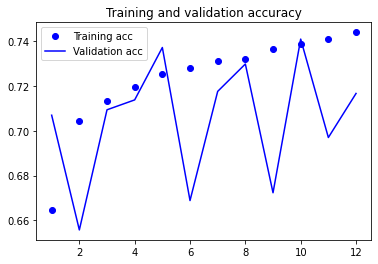

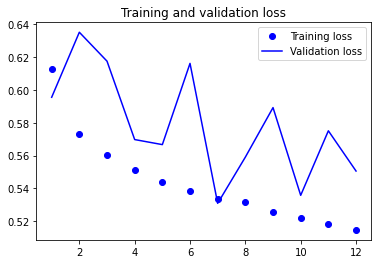

In [ ]:
plot_outputs()

# Model 2: First GRU Model <a class="anchor" id="model7"></a>
-----------------

In [ ]:
model = build_GRU()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 375s 191ms/step - loss: 0.6257 - acc: 0.6372 - f1_score: 0.6285 - val_loss: 0.5970 - val_acc: 0.6812 - val_f1_score: 0.5376
Epoch 2/50
1948/1948 [==============================] - 380s 195ms/step - loss: 0.5644 - acc: 0.7074 - f1_score: 0.7038 - val_loss: 0.6076 - val_acc: 0.6782 - val_f1_score: 0.5480
Epoch 3/50
1948/1948 [==============================] - 393s 202ms/step - loss: 0.5476 - acc: 0.7190 - f1_score: 0.7139 - val_loss: 0.5433 - val_acc: 0.7237 - val_f1_score: 0.5544
Epoch 4/50
1948/1948 [==============================] - 394s 202ms/step - loss: 0.5383 - acc: 0.7258 - f1_score: 0.7205 - val_loss: 0.5836 - val_acc: 0.6919 - val_f1_score: 0.5519
Epoch 5/50
1948/1948 [==============================] - 395s 203ms/step - loss: 0.5308 - acc: 0.7311 - f1_score: 0.7259 - val_loss: 0.5857 - val_acc: 0.6908 - val_f1_score: 0.5506
Epoch 6/50
1948/1948 [==============================] - 394s 202ms/step - loss: 0.5235 - acc: 0.7369

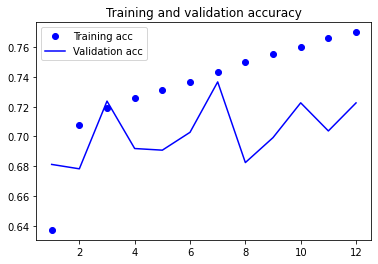

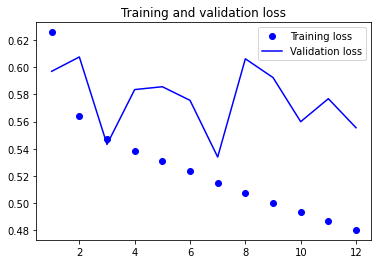

In [ ]:
plot_outputs()

# Tuning: Dropout <a class="anchor" id="dropout"></a>
------------

## Model 3: Rate 20% <a class="anchor" id="model3"></a>
-----------------------

In [ ]:
model = build_dropout(0.2, 0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                5248      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 1302s 666ms/step - loss: 0.6167 - acc: 0.6651 - f1_score: 0.6480 - val_loss: 0.5147 - val_acc: 0.7549 - val_f1_score: 0.5096
Epoch 2/50
1949/1949 [==============================] - 1299s 666ms/step - loss: 0.5791 - acc: 0.7013 - f1_score: 0.6969 - val_loss: 0.5496 - val_acc: 0.7273 - val_f1_score: 0.5492
Epoch 3/50
1949/1949 [==============================] - 1298s 666ms/step - loss: 0.5662 - acc: 0.7101 - f1_score: 0.7069 - val_loss: 0.5490 - val_acc: 0.7282 - val_f1_score: 0.5525
Epoch 4/50
1949/1949 [==============================] - 1297s 665ms/step - loss: 0.5591 - acc: 0.7155 - f1_score: 0.7128 - val_loss: 0.5545 - val_acc: 0.7182 - val_f1_score: 0.5550
Epoch 5/50
1949/1949 [==============================] - 1299s 667ms/step - loss: 0.5539 - acc: 0.7164 - f1_score: 0.7125 - val_loss: 0.5958 - val_acc: 0.6659 - val_f1_score: 0.5422
Epoch 6/50
1949/1949 [==============================] - 1300s 667ms/step - loss: 0.5524 - acc: 

Below I have included graphs showing the training and validation accuracy and loss of this model:


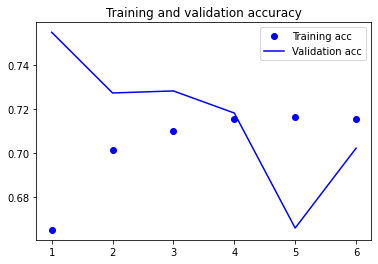

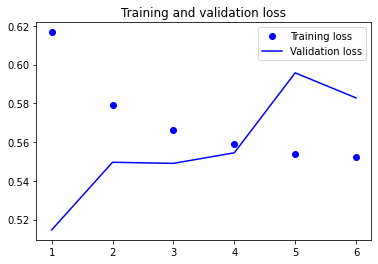

In [ ]:
plot_outputs()

## Model 4: Rate 40% <a class="anchor" id="model4"></a>
-----------------------

In [ ]:
model = build_dropout(0.4, 0.4)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_4 (LSTM)               (None, 32)                5248      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 1310s 666ms/step - loss: 0.6251 - acc: 0.6530 - f1_score: 0.6315 - val_loss: 0.5584 - val_acc: 0.7060 - val_f1_score: 0.5371
Epoch 2/50
1949/1949 [==============================] - 1299s 667ms/step - loss: 0.5874 - acc: 0.6960 - f1_score: 0.6888 - val_loss: 0.5761 - val_acc: 0.7204 - val_f1_score: 0.5435
Epoch 3/50
1949/1949 [==============================] - 1298s 666ms/step - loss: 0.5758 - acc: 0.7035 - f1_score: 0.7025 - val_loss: 0.5578 - val_acc: 0.7542 - val_f1_score: 0.5282
Epoch 4/50
1949/1949 [==============================] - 1303s 669ms/step - loss: 0.5670 - acc: 0.7088 - f1_score: 0.7091 - val_loss: 0.5924 - val_acc: 0.6855 - val_f1_score: 0.5471
Epoch 5/50
1949/1949 [==============================] - 1303s 669ms/step - loss: 0.5609 - acc: 0.7117 - f1_score: 0.7131 - val_loss: 0.6201 - val_acc: 0.6683 - val_f1_score: 0.5445
Epoch 6/50
1949/1949 [==============================] - 1298s 666ms/step - loss: 0.5545 - acc: 

Graphs showing the training and validation loss and accuracy can be found below:

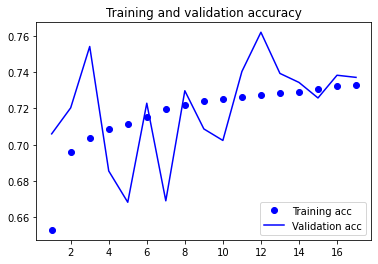

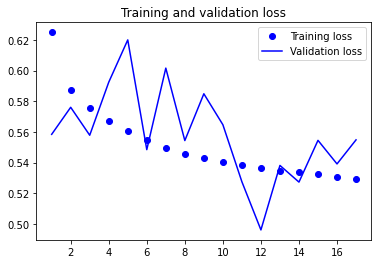

In [ ]:
plot_outputs()

## Model 5: Rate 30% <a class="anchor" id="model5"></a>
-----------------------

In [ ]:
model = build_dropout(0.3, 0.3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                5248      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1949/1949 [==============================] - 1298s 665ms/step - loss: 0.6244 - acc: 0.6547 - f1_score: 0.6188 - val_loss: 0.6667 - val_acc: 0.6344 - val_f1_score: 0.5274
Epoch 2/50
1949/1949 [==============================] - 1296s 665ms/step - loss: 0.5925 - acc: 0.6911 - f1_score: 0.6845 - val_loss: 0.5666 - val_acc: 0.7095 - val_f1_score: 0.5434
Epoch 3/50
1949/1949 [==============================] - 1296s 665ms/step - loss: 0.5765 - acc: 0.7054 - f1_score: 0.7040 - val_loss: 0.5879 - val_acc: 0.7356 - val_f1_score: 0.5336
Epoch 4/50
1949/1949 [==============================] - 1298s 666ms/step - loss: 0.5657 - acc: 0.7100 - f1_score: 0.7077 - val_loss: 0.5598 - val_acc: 0.6891 - val_f1_score: 0.5470
Epoch 5/50
1949/1949 [==============================] - 1295s 664ms/step - loss: 0.5623 - acc: 0.7115 - f1_score: 0.7093 - val_loss: 0.5263 - val_acc: 0.7334 - val_f1_score: 0.5461
Epoch 6/50
1949/1949 [==============================] - 1295s 664ms/step - loss: 0.5569 - acc: 

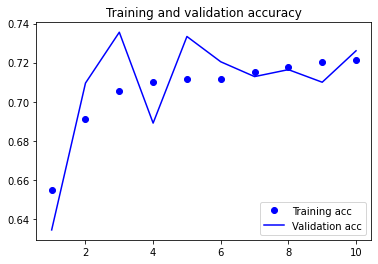

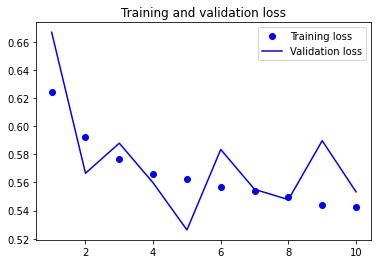

In [ ]:
plot_outputs()

# Tuning: Number of Layers <a class="anchor" id="layers"></a>
----------------------------
Next, I will be changing the architecture by adding layers. Adding layers will increase the capacity of the network, making it more likely to learn important patterns that can allow it to make more accurate predictions. 

## Failed Model: 2 Layers <a class="anchor" id="model6"></a>
--------------------
For the next model, I will be increasing the number of LSTM layers to 2. The model definition can be seen below. 

In [ ]:
model = build_layers(0.4, 0.4, 2)

In [ ]:
history = train(model, 50)

# Tuning: Learning Rate <a class="anchor" id="Learning-Rate"></a>
----------------------------

## Model 6: 0.003 <a class="anchor" id="model8"></a>
-----------------

In [ ]:
model = build_learning_rate(0.4, 0.4, 0.003)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 961s 492ms/step - loss: 0.6466 - acc: 0.6339 - f1_score: 0.6088 - val_loss: 0.5578 - val_acc: 0.7520 - val_f1_score: 0.4642
Epoch 2/50
1948/1948 [==============================] - 961s 493ms/step - loss: 0.6058 - acc: 0.6785 - f1_score: 0.6810 - val_loss: 0.5342 - val_acc: 0.7405 - val_f1_score: 0.5172
Epoch 3/50
1948/1948 [==============================] - 956s 491ms/step - loss: 0.5767 - acc: 0.6950 - f1_score: 0.6934 - val_loss: 0.5991 - val_acc: 0.6541 - val_f1_score: 0.5379
Epoch 4/50
1948/1948 [==============================] - 948s 487ms/step - loss: 0.5648 - acc: 0.7047 - f1_score: 0.7019 - val_loss: 0.5297 - val_acc: 0.7172 - val_f1_score: 0.5499
Epoch 5/50
1948/1948 [==============================] - 951s 488ms/step - loss: 0.5566 - acc: 0.7116 - f1_score: 0.7040 - val_loss: 0.5480 - val_acc: 0.7324 - val_f1_score: 0.5512
Epoch 6/50
1948/1948 [==============================] - 948s 487ms/step - loss: 0.5533 - acc: 0.7128

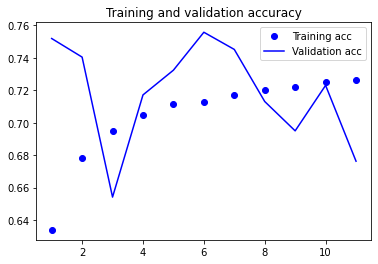

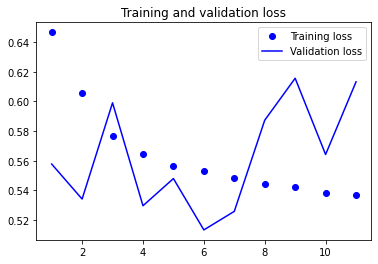

In [ ]:
plot_outputs()

## Model 7: 0.006 <a class="anchor" id="model9"></a>
--------------

In [ ]:
model = build_learning_rate(0.4, 0.4, 0.006)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                5248      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 949s 486ms/step - loss: 0.6529 - acc: 0.6082 - f1_score: 0.5692 - val_loss: 0.5847 - val_acc: 0.7110 - val_f1_score: 0.5389
Epoch 2/50
1948/1948 [==============================] - 948s 487ms/step - loss: 0.5722 - acc: 0.6999 - f1_score: 0.6953 - val_loss: 0.5328 - val_acc: 0.7320 - val_f1_score: 0.5499
Epoch 3/50
1948/1948 [==============================] - 942s 483ms/step - loss: 0.5553 - acc: 0.7135 - f1_score: 0.7086 - val_loss: 0.5805 - val_acc: 0.6842 - val_f1_score: 0.5523
Epoch 4/50
1948/1948 [==============================] - 947s 486ms/step - loss: 0.5472 - acc: 0.7200 - f1_score: 0.7151 - val_loss: 0.5429 - val_acc: 0.7308 - val_f1_score: 0.5509
Epoch 5/50
1948/1948 [==============================] - 946s 486ms/step - loss: 0.5409 - acc: 0.7248 - f1_score: 0.7204 - val_loss: 0.5219 - val_acc: 0.7342 - val_f1_score: 0.5531
Epoch 6/50
1948/1948 [==============================] - 946s 486ms/step - loss: 0.5382 - acc: 0.7280

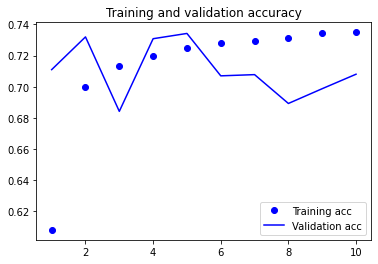

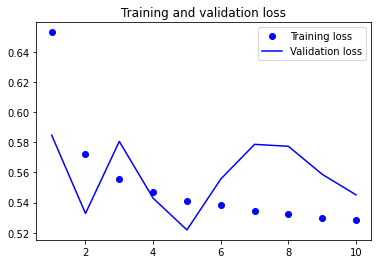

In [ ]:
plot_outputs()

## Model 8: 0.004 <a class="anchor" id="model10"></a>
----------------

In [ ]:
model = build_learning_rate(0.4, 0.4, 0.004)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                5248      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 941s 482ms/step - loss: 0.6496 - acc: 0.6230 - f1_score: 0.6156 - val_loss: 0.6399 - val_acc: 0.6425 - val_f1_score: 0.5194
Epoch 2/50
1948/1948 [==============================] - 939s 482ms/step - loss: 0.5950 - acc: 0.6792 - f1_score: 0.6757 - val_loss: 0.5098 - val_acc: 0.7461 - val_f1_score: 0.5302
Epoch 3/50
1948/1948 [==============================] - 933s 479ms/step - loss: 0.5675 - acc: 0.7006 - f1_score: 0.6981 - val_loss: 0.5231 - val_acc: 0.7360 - val_f1_score: 0.5469
Epoch 4/50
1948/1948 [==============================] - 936s 481ms/step - loss: 0.5600 - acc: 0.7072 - f1_score: 0.7017 - val_loss: 0.6012 - val_acc: 0.6688 - val_f1_score: 0.5451
Epoch 5/50
1948/1948 [==============================] - 932s 479ms/step - loss: 0.5539 - acc: 0.7122 - f1_score: 0.7074 - val_loss: 0.5996 - val_acc: 0.7000 - val_f1_score: 0.5514
Epoch 6/50
1948/1948 [==============================] - 934s 479ms/step - loss: 0.5508 - acc: 0.7155

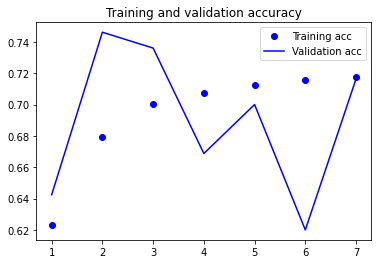

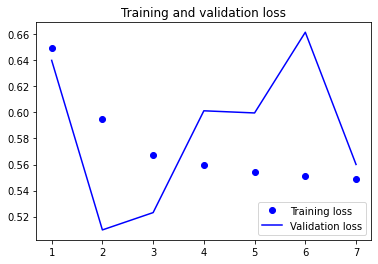

In [ ]:
plot_outputs()

## Model 9: 0.01 <a class="anchor" id="model11"></a>
-----------------

In [ ]:
model = build_learning_rate(0.4, 0.4, 0.01)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                5248      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 924s 473ms/step - loss: 0.6234 - acc: 0.6426 - f1_score: 0.6330 - val_loss: 0.6179 - val_acc: 0.6517 - val_f1_score: 0.5343
Epoch 2/50
1948/1948 [==============================] - 922s 473ms/step - loss: 0.5695 - acc: 0.7014 - f1_score: 0.6953 - val_loss: 0.5112 - val_acc: 0.7426 - val_f1_score: 0.5405
Epoch 3/50
1948/1948 [==============================] - 923s 474ms/step - loss: 0.5560 - acc: 0.7121 - f1_score: 0.7063 - val_loss: 0.5542 - val_acc: 0.7160 - val_f1_score: 0.5545
Epoch 4/50
1948/1948 [==============================] - 928s 476ms/step - loss: 0.5481 - acc: 0.7188 - f1_score: 0.7128 - val_loss: 0.5544 - val_acc: 0.7189 - val_f1_score: 0.5549
Epoch 5/50
1948/1948 [==============================] - 931s 478ms/step - loss: 0.5484 - acc: 0.7195 - f1_score: 0.7162 - val_loss: 0.5632 - val_acc: 0.7072 - val_f1_score: 0.5524
Epoch 6/50
1948/1948 [==============================] - 921s 473ms/step - loss: 0.5425 - acc: 0.7239

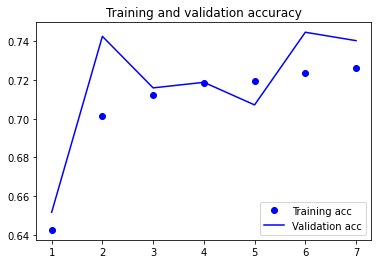

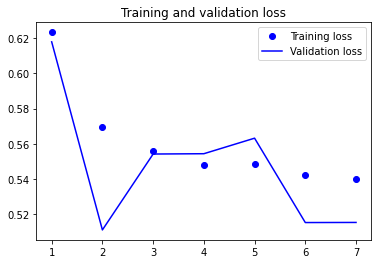

In [ ]:
plot_outputs()

## Model 10: Adam Optimizer
---------------------------

In [ ]:
model = build_optimizer(0.4, 0.4, 'Adam')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_4 (LSTM)               (None, 32)                5248      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 939s 479ms/step - loss: 0.6668 - acc: 0.5899 - f1_score: 0.5632 - val_loss: 0.6738 - val_acc: 0.7213 - val_f1_score: 0.0985
Epoch 2/50
1948/1948 [==============================] - 938s 482ms/step - loss: 0.6543 - acc: 0.6032 - f1_score: 0.5943 - val_loss: 0.6336 - val_acc: 0.6346 - val_f1_score: 0.5206
Epoch 3/50
1948/1948 [==============================] - 937s 481ms/step - loss: 0.6840 - acc: 0.5500 - f1_score: 0.5163 - val_loss: 0.6825 - val_acc: 0.5772 - val_f1_score: 0.3881
Epoch 4/50
1948/1948 [==============================] - 943s 484ms/step - loss: 0.6586 - acc: 0.6054 - f1_score: 0.5992 - val_loss: 0.6778 - val_acc: 0.5028 - val_f1_score: 0.4472
Epoch 5/50
1948/1948 [==============================] - 948s 487ms/step - loss: 0.6140 - acc: 0.6635 - f1_score: 0.6666 - val_loss: 0.5463 - val_acc: 0.7183 - val_f1_score: 0.5209
Epoch 6/50
1948/1948 [==============================] - 950s 488ms/step - loss: 0.6087 - acc: 0.6686

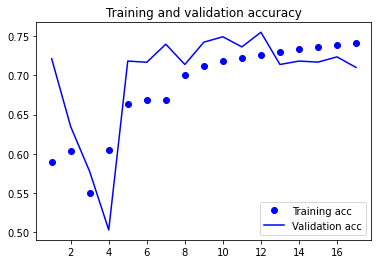

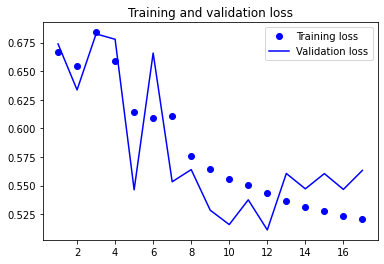

In [ ]:
plot_outputs()

## Model 11: Nadam Optimizer
---------------------------

In [ ]:
model = build_optimizer(0.4, 0.4, 'Nadam')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_5 (LSTM)               (None, 32)                5248      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1948/1948 [==============================] - 936s 479ms/step - loss: 0.6860 - acc: 0.5421 - f1_score: 0.4925 - val_loss: 0.6686 - val_acc: 0.6272 - val_f1_score: 0.3441
Epoch 2/50
1948/1948 [==============================] - 938s 482ms/step - loss: 0.6830 - acc: 0.5571 - f1_score: 0.5312 - val_loss: 0.6615 - val_acc: 0.6451 - val_f1_score: 0.3188
Epoch 3/50
1948/1948 [==============================] - 939s 482ms/step - loss: 0.6582 - acc: 0.6065 - f1_score: 0.5848 - val_loss: 0.6460 - val_acc: 0.7033 - val_f1_score: 0.4463
Epoch 4/50
1948/1948 [==============================] - 939s 482ms/step - loss: 0.6432 - acc: 0.6360 - f1_score: 0.6279 - val_loss: 0.5951 - val_acc: 0.6731 - val_f1_score: 0.5200
Epoch 5/50
1948/1948 [==============================] - 935s 480ms/step - loss: 0.5948 - acc: 0.6846 - f1_score: 0.6810 - val_loss: 0.5825 - val_acc: 0.6914 - val_f1_score: 0.5375
Epoch 6/50
1948/1948 [==============================] - 937s 481ms/step - loss: 0.5667 - acc: 0.7046

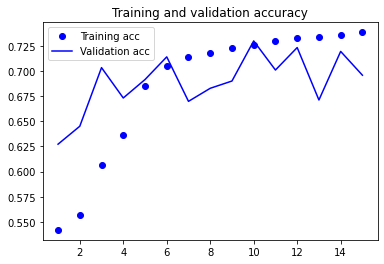

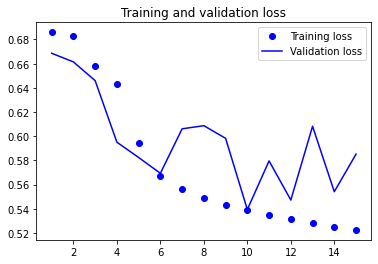

In [ ]:
plot_outputs()

# Training Final Model <a class="anchor" id="FinalModel"></a>
-----------------------------------

In [ ]:
final_model = build_dropout(0.4, 0.4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_final_model(final_model, 12)

Epoch 1/12
4094/4094 [==============================] - 2717s 663ms/step - loss: 0.5313 - acc: 0.7484 - f1_score: 0.2679
Epoch 2/12
4094/4094 [==============================] - 2670s 652ms/step - loss: 0.5086 - acc: 0.7551 - f1_score: 0.3336
Epoch 3/12
4094/4094 [==============================] - 2645s 646ms/step - loss: 0.4906 - acc: 0.7692 - f1_score: 0.4041
Epoch 4/12
4094/4094 [==============================] - 2790s 681ms/step - loss: 0.4811 - acc: 0.7772 - f1_score: 0.4287
Epoch 5/12
4094/4094 [==============================] - 2809s 686ms/step - loss: 0.4769 - acc: 0.7800 - f1_score: 0.4405
Epoch 6/12
4094/4094 [==============================] - 2703s 660ms/step - loss: 0.4732 - acc: 0.7827 - f1_score: 0.4501
Epoch 7/12
4094/4094 [==============================] - 2753s 672ms/step - loss: 0.4704 - acc: 0.7841 - f1_score: 0.4538
Epoch 8/12
4094/4094 [==============================] - 2595s 634ms/step - loss: 0.4685 - acc: 0.7856 - f1_score: 0.4594
Epoch 9/12
4094/4094 [==========

In [ ]:
y_pred = final_model.predict(x_test)

In [ ]:
y_pred_labels = np.where(y_pred > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
print('Accuracy: %.2f' % (accuracy_score(y_test, y_pred_labels)))
print('Precision score: %.2f' % (precision_score(y_test, y_pred_labels)))
print('Recall score: %.2f' % (recall_score(y_test, y_pred_labels)))
print('F1 score: %.2f' % (f1_score(y_test, y_pred_labels)))

Accuracy: 0.78
Precision score: 0.74
Recall score: 0.27
F1 score: 0.40


In [ ]:
%%shell
jupyter nbconvert --to html /content/LSTMGRULayers.ipynb

[NbConvertApp] Converting notebook /content/LSTMGRULayers.ipynb to html
[NbConvertApp] Writing 621334 bytes to /content/LSTMGRULayers.html
